<a href="https://colab.research.google.com/github/RainaVardhan/DS4002-Project-2/blob/main/SCRIPTS/DS_PROJECT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone repository to get data

In [142]:
!git clone https://github.com/RainaVardhan/DS4002-Project-2.git

fatal: destination path 'DS4002-Project-2' already exists and is not an empty directory.


Import libraries

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

Load data

In [144]:
# Loading the dataset from CSV file
df = pd.read_csv('/content/DS4002-Project-2/DATA/1950-2023_all_tornadoes.csv')
df.head(10)

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,len,wid,ns,sn,sg,f1,f2,f3,f4,fc
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,...,16,10,1,1,1,25,0,0,0,0
1,193,1950,10,9,1950-10-09,02:15:00,3,NC,37,9,...,2,880,1,1,1,47,0,0,0,0
2,195,1950,11,20,1950-11-20,02:20:00,3,KY,21,1,...,0,10,1,1,1,177,0,0,0,0
3,196,1950,11,20,1950-11-20,04:00:00,3,KY,21,2,...,0,10,1,1,1,209,0,0,0,0
4,197,1950,11,20,1950-11-20,07:30:00,3,MS,28,14,...,2,37,1,1,1,101,0,0,0,0
5,194,1950,11,4,1950-11-04,17:00:00,3,PA,42,5,...,16,100,1,1,1,71,11,0,0,0
6,198,1950,12,2,1950-12-02,15:00:00,3,IL,17,7,...,19,50,1,1,1,119,117,0,0,0
7,199,1950,12,2,1950-12-02,16:00:00,3,IL,17,8,...,18,200,1,1,1,119,5,0,0,0
8,200,1950,12,2,1950-12-02,16:25:00,3,AR,5,12,...,8,10,1,1,1,65,0,0,0,0
9,201,1950,12,2,1950-12-02,17:30:00,3,IL,17,9,...,10,50,1,1,1,157,0,0,0,0


Clean data

In [145]:
# Convert date to datetime and filtered for Minnesota state
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
mn_df = df[df['st'] == 'MN']
mn_df['loss']

,loss
145,3
345,6
361,5
414,7
645,6
...,...
71167,0
71249,"10,000"
71383,0
71385,0


Map property loss data for years prior to 1996

In [146]:
pd.options.display.float_format = '{:,.0f}'.format


In [147]:
mapping = {1.0: 50, 2.0: 275, 3.0: 2750, 4.0: 27500, 5.0: 275000, 6.0: 2750000,
           7.0: 27500000, 8.0: 275000000, 9.0: 5000000000}

# Apply mapping for entries before 1996
mn_df.loc[mn_df['date'].dt.year < 1996, 'loss'] = mn_df.loc[mn_df['date'].dt.year < 1996, 'loss'].map(mapping).fillna(mn_df['loss'])

# Adjust entries from 1996 and onward to reflect millions of dollars
mn_df.loc[mn_df['date'].dt.year >= 1996, 'loss'] = mn_df.loc[mn_df['date'].dt.year >= 1996, 'loss'].apply(
    lambda x: x * 1_000_000 if x < 1_000 else x
)

# Display the updated 'loss' column
mn_df['loss']

# Display the updated 'loss' column
mn_df[['loss','om','date','mag']]


,loss,om,date,mag
145,"2,750",141,1950-06-15,2
345,"2,750,000",149,1951-06-19,4
361,"275,000",165,1951-06-25,2
414,"27,500,000",195,1951-07-20,3
645,"2,750,000",171,1952-06-23,2
...,...,...,...,...
71167,0,623128,2023-07-25,0
71249,"10,000",623248,2023-08-13,0
71383,0,623318,2023-09-23,-9
71385,0,623320,2023-09-23,-9


In [148]:
# Group data by year and aggregate by property loss, crop loss, and tornado frequency
yearly_data = mn_df.groupby(mn_df['date'].dt.year).agg({
    'loss': 'sum',
    'om': 'count'
}).reset_index()

yearly_data.rename(columns={'om': 'num_tornadoes'}, inplace=True)
yearly_data

,date,loss,num_tornadoes
0,1950,"2,750",1
1,1951,"30,525,000",3
2,1952,"8,360,000",7
3,1953,"3,605,250",8
4,1954,"662,750",7
...,...,...,...
69,2019,"3,946,000",53
70,2020,"4,983,000",60
71,2021,"4,207,000",65
72,2022,"10,420,000",71


In [149]:
# Checking for null values
yearly_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           74 non-null     int32  
 1   loss           74 non-null     float64
 2   num_tornadoes  74 non-null     int64  
dtypes: float64(1), int32(1), int64(1)
memory usage: 1.6 KB


EDA

In [150]:
yearly_data.set_index('date',inplace=True)

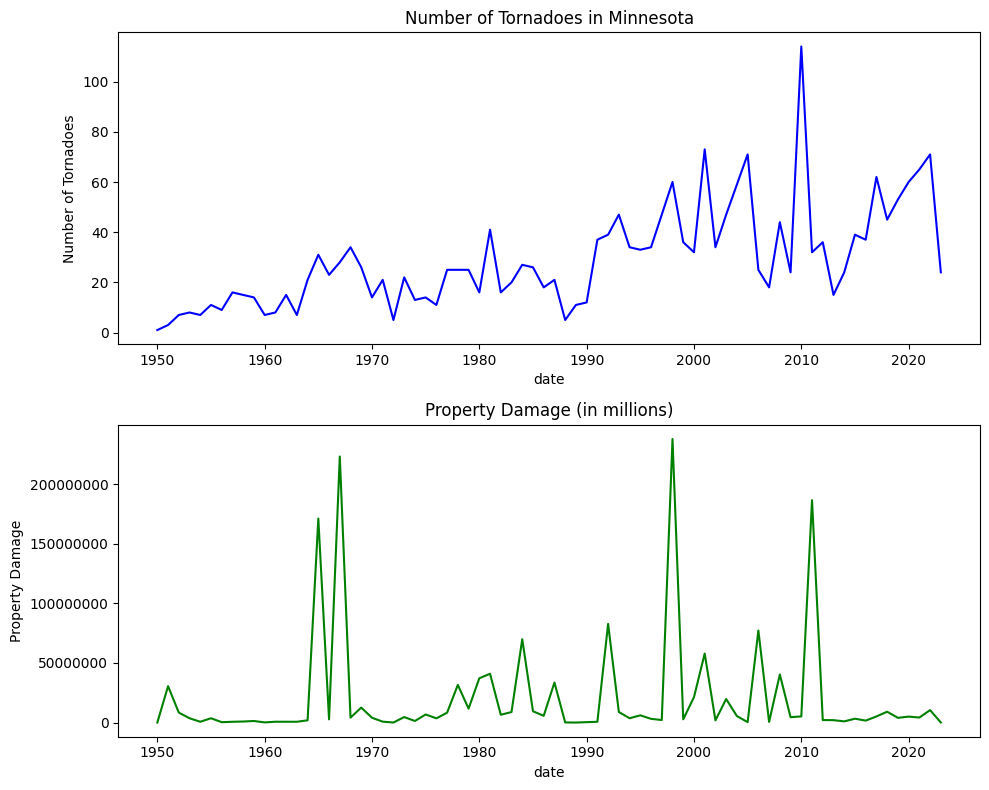

In [151]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot the number of tornadoes each year
yearly_data['num_tornadoes'].plot(ax=ax[0], title='Number of Tornadoes in Minnesota', color='blue')
ax[0].set_ylabel('Number of Tornadoes')

# Plot the property damage each year
yearly_data['loss'].plot(ax=ax[1], title='Property Damage (in millions)', color='green')
ax[1].set_ylabel('Property Damage')

ax[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

In [152]:
# Perform ADF test to check for stationary of tornado data
result = adfuller(yearly_data['num_tornadoes'])
print(f"ADF Statistic for Number of Tornadoes: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic for Number of Tornadoes: -3.163187728851386
p-value: 0.022216872185095472


Preprocessing for ARIMA

In [153]:
# Applying differencing if series is non-stationary (p-value > 0.05)
if result[1] > 0.05:
    yearly_data['num_tornadoes_diff'] = yearly_data['num_tornadoes'].diff().dropna()
    result = adfuller(yearly_data['num_tornadoes_diff'])
    stationarity_interpretation = "Stationary" if result[1] < 0.05 else "Non-Stationary"

else:
    yearly_data['num_tornadoes_diff'] = yearly_data['num_tornadoes']
    stationarity_interpretation = "Stationary"

print(f"ADF Statistic after differencing: {result[0]}")
print(f"p-value after differencing: {result[1]}")
print(f"Interpretation: The series is {stationarity_interpretation}.")

ADF Statistic after differencing: -3.163187728851386
p-value after differencing: 0.022216872185095472
Interpretation: The series is Stationary.


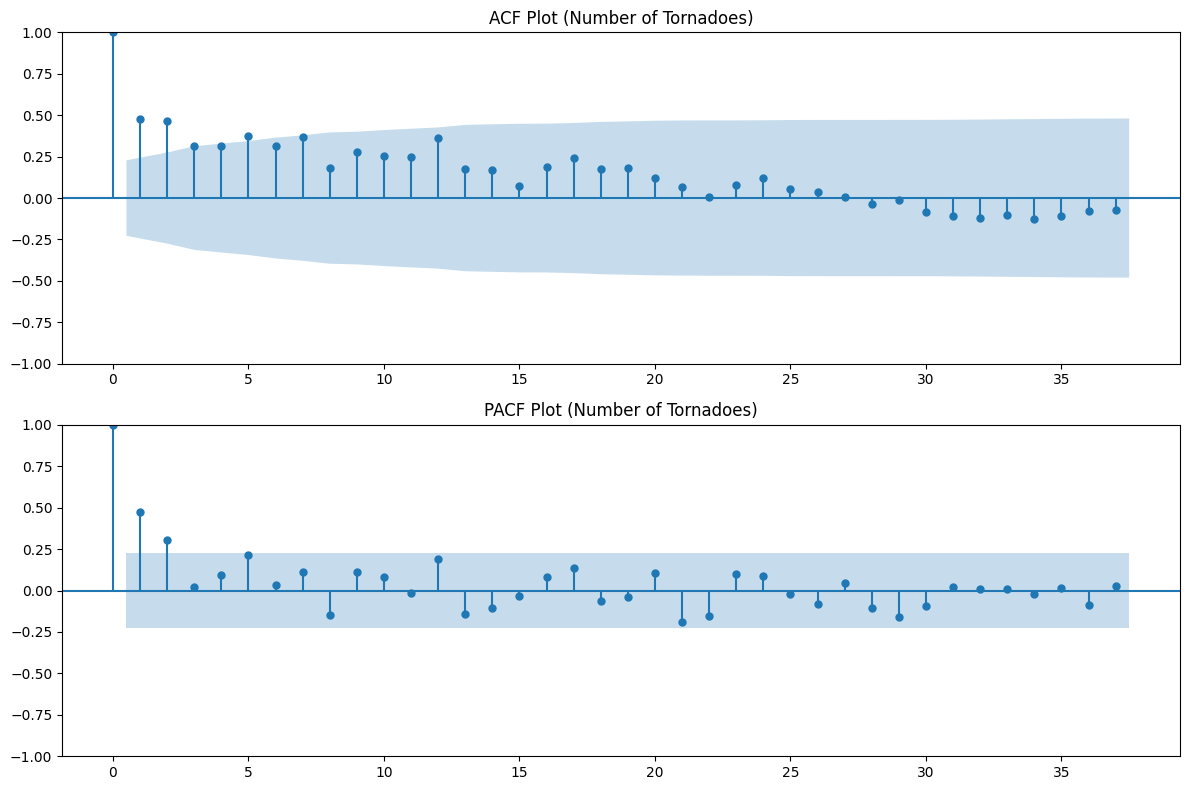

In [154]:
max_lags = min(40, len(yearly_data['num_tornadoes']) // 2)
fig, ax = plt.subplots(2, figsize=(12, 8))

# ACF plot to find 'q' (moving average term)
plot_acf(yearly_data['num_tornadoes'], lags=max_lags, ax=ax[0])
ax[0].set_title('ACF Plot (Number of Tornadoes)')

# PACF plot to find 'p' (autoregressive term)
plot_pacf(yearly_data['num_tornadoes'], lags=max_lags, ax=ax[1])
ax[1].set_title('PACF Plot (Number of Tornadoes)')

plt.tight_layout()
plt.show()

Fit model for tornado data

In [155]:
# Fit the ARIMA model with parameters p, d, q
model = ARIMA(yearly_data['num_tornadoes_diff'].dropna(), order=(1, 1, 1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     num_tornadoes_diff   No. Observations:                   74
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -307.800
Date:                Tue, 29 Oct 2024   AIC                            621.600
Time:                        04:07:20   BIC                            628.471
Sample:                             0   HQIC                           624.338
                                 - 74                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0302      0.137      0.220      0.826      -0.239       0.299
ma.L1         -0.8181      0.083     -9.851      0.000      -0.981      -0.655
sigma2       265.2081     26.142     10.145      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


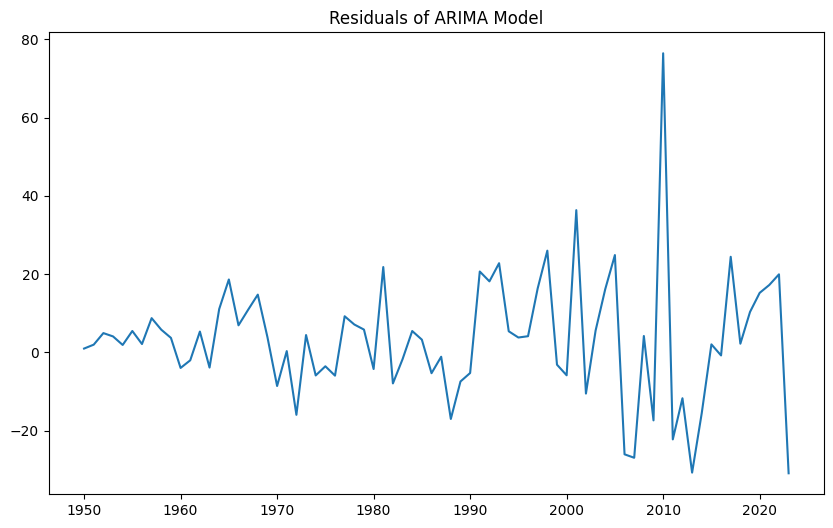

In [156]:
# Plot residuals of the fitted model to check if they resemble white noise
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.show()

Conduct forecasting for tornado data

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


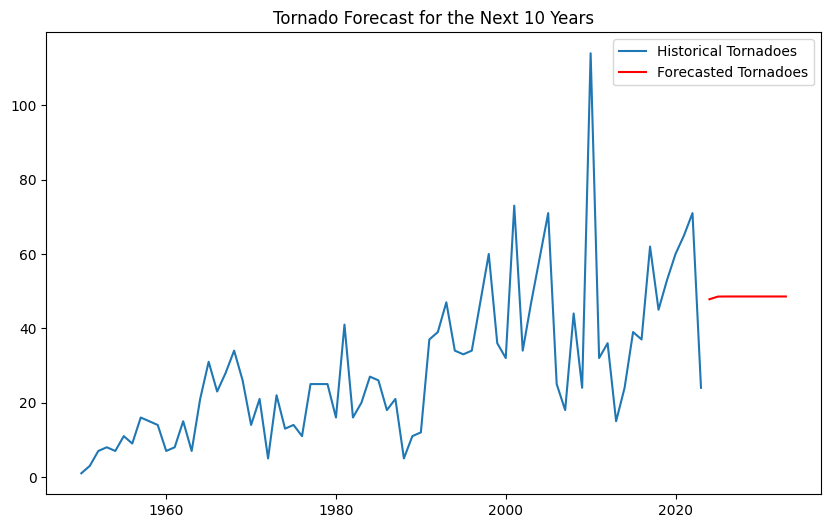

In [157]:
# Forecast for the next 10 years based on the fitted ARIMA model
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)
forecast_years = np.arange(yearly_data.index.max() + 1, yearly_data.index.max() + forecast_steps + 1)

# Plotting historical tornado data and forcasted tornadoes for the next 10 years
plt.figure(figsize=(10, 6))
plt.plot(yearly_data.index, yearly_data['num_tornadoes'], label='Historical Tornadoes')
plt.plot(forecast_years, forecast, label='Forecasted Tornadoes', color='red')
plt.title('Tornado Forecast for the Next 10 Years')
plt.legend()
plt.show()

In [158]:
# Evaluate the ARIMA model using AIC and BIC metrics
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

AIC: 621.5996808309274
BIC: 628.4710591543725


In [159]:
# Split data into training and testing sets for model validation
train_size = int(len(yearly_data) * 0.8)
train, test = yearly_data['num_tornadoes_diff'][:train_size], yearly_data['num_tornadoes_diff'][train_size:]

# Fit the ARIMA model on training data and forecast on the test data
p = 1
d = 1
q = 1
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

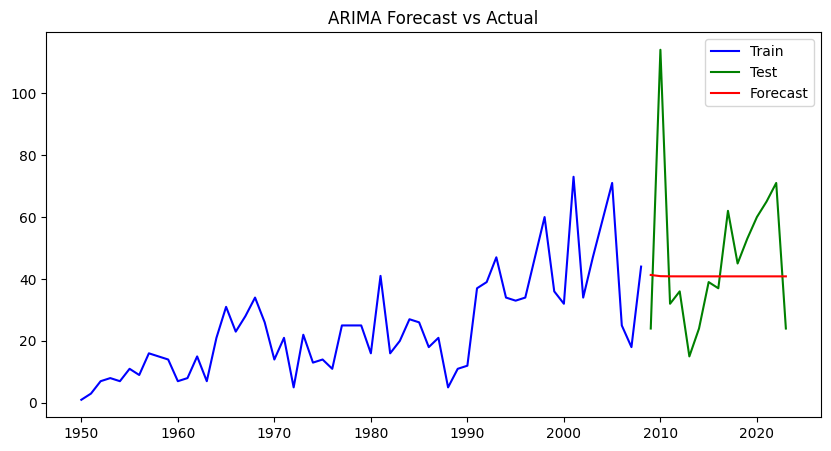

In [160]:
# Plot the training data, test data, and forecasted values
plt.figure(figsize=(10, 5))
plt.plot(yearly_data.index[:train_size], train, label='Train', color='blue')
plt.plot(yearly_data.index[train_size:], test, label='Test', color='green')
plt.plot(yearly_data.index[train_size:], forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()

In [161]:
# Calculate RMSE to evaluate model's accuracy
rmse = mean_squared_error(test, forecast, squared=False)
print(f"RMSE: {rmse}")

RMSE: 25.125179439897508


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [162]:
# Applying differencing if series is non-stationary (p-value > 0.05)
if result[1] > 0.05:
    yearly_data['loss_diff'] = yearly_data['loss'].diff().dropna()
    result = adfuller(yearly_data['loss_diff'])
    stationarity_interpretation = "Stationary" if result[1] < 0.05 else "Non-Stationary"

else:
    yearly_data['loss_diff'] = yearly_data['loss']
    stationarity_interpretation = "Stationary"

print(f"ADF Statistic after differencing: {result[0]}")
print(f"p-value after differencing: {result[1]}")
print(f"Interpretation: The series is {stationarity_interpretation}.")

ADF Statistic after differencing: -3.163187728851386
p-value after differencing: 0.022216872185095472
Interpretation: The series is Stationary.


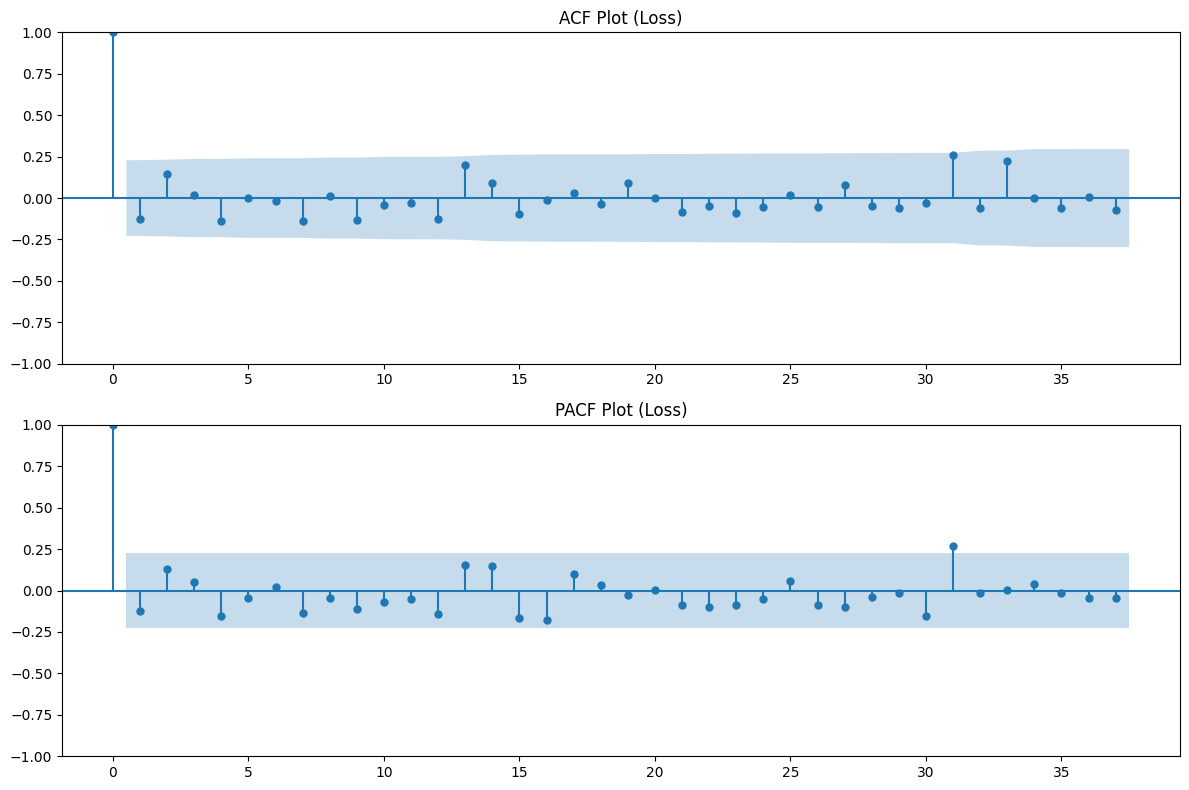

In [163]:
max_lags = min(40, len(yearly_data['loss']) // 2)
fig, ax = plt.subplots(2, figsize=(12, 8))

# ACF plot to find 'q' (moving average term)
plot_acf(yearly_data['loss'], lags=max_lags, ax=ax[0])
ax[0].set_title('ACF Plot (Loss)')

# PACF plot to find 'p' (autoregressive term)
plot_pacf(yearly_data['loss'], lags=max_lags, ax=ax[1])
ax[1].set_title('PACF Plot (Loss)')

plt.tight_layout()
plt.show()

Fit model for property loss data

In [164]:
# Fit the ARIME model with parameters p, d, q
model = ARIMA(yearly_data['loss'].dropna(), order=(1, 1, 1))
model_fit = model.fit()

print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   loss   No. Observations:                   74
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1397.275
Date:                Tue, 29 Oct 2024   AIC                           2800.549
Time:                        04:07:22   BIC                           2807.421
Sample:                             0   HQIC                          2803.288
                                 - 74                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1170      0.514     -0.228      0.820      -1.124       0.890
ma.L1         -0.9837      0.135     -7.270      0.000      -1.249      -0.719
sigma2      2.975e+15        nan        nan        n

Forecasting for property loss data

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


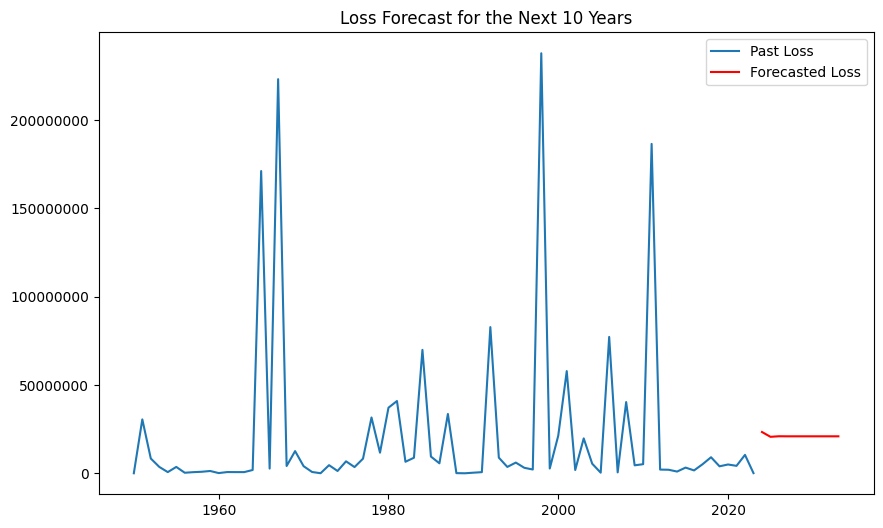

In [165]:
# Forecast for the next 10 years based on the fitted ARIMA model
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)
forecast_years = np.arange(yearly_data.index.max() + 1, yearly_data.index.max() + forecast_steps + 1)

# Plotting historical property loss data and forcasted loss for the next 10 years
plt.figure(figsize=(10, 6))
plt.plot(yearly_data.index, yearly_data['loss'], label='Past Loss')
plt.plot(forecast_years, forecast, label='Forecasted Loss', color='red')
plt.title('Loss Forecast for the Next 10 Years')
plt.legend()
plt.ticklabel_format(style='plain', axis='y')

plt.show()

In [166]:
# Evaluate the ARIMA model using AIC and BIC metrics
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

AIC: 2800.549269577975
BIC: 2807.42064790142


In [167]:
# Split data into training and testing sets for model validation
train_size = int(len(yearly_data) * 0.8)
train, test = yearly_data['loss'][:train_size], yearly_data['loss'][train_size:]

# Fit the ARIMA model on training data and forecast on the test data
p = 1
d = 1
q = 1
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

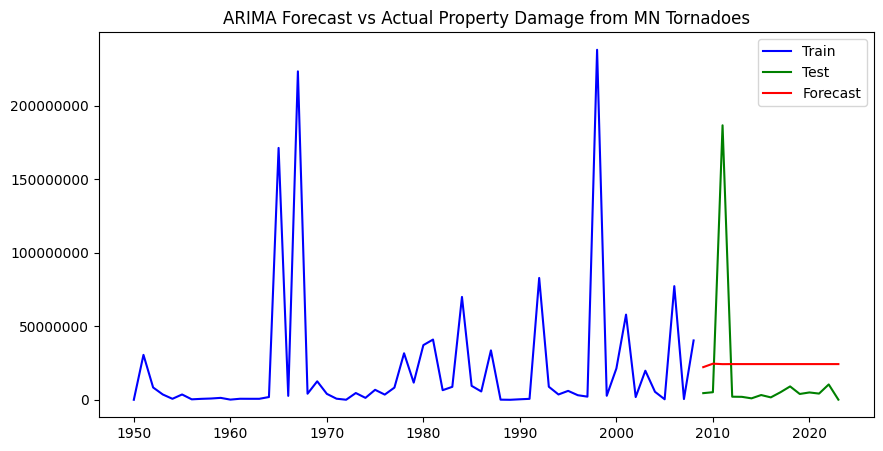

In [168]:
# Plot the training data, test data, and forecasted values
plt.figure(figsize=(10, 5))
plt.plot(yearly_data.index[:train_size], train, label='Train', color='blue')
plt.plot(yearly_data.index[train_size:], test, label='Test', color='green')
plt.plot(yearly_data.index[train_size:], forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast vs Actual Property Damage from MN Tornadoes')
plt.ticklabel_format(style='plain', axis='y')

plt.show()

In [169]:
# Calculate RMSE to evaluate model's accuracy
rmse = mean_squared_error(test, forecast, squared=False)
print(f"RMSE: {rmse}")

RMSE: 46253651.74690855


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
